Temporal output of expected Sq and target covered by FLM membrane

In [ ]:
from chimerax.color_key import show_key
from chimerax.core import colors
from chimerax.std_commands.wait import wait
from chimerax.core.commands import (BoolArg, Bounded, CmdDesc, ColormapArg,
                                    ColormapRangeArg, Int2Arg, IntArg,
                                    SurfacesArg, StringArg)
from chimerax.core.commands.cli import EnumOf
from chimerax.map.volumecommand import volume
from chimerax.std_commands.cd import (cd)
from os.path import exists
from numpy import (arccos, array, full, inf, isnan, mean, nan, nanmax, nanmean,
                   nanmin, pi, ravel_multi_index, sign, split, sqrt, subtract,
                   count_nonzero, swapaxes, savetxt, column_stack,nansum, nanstd,
                   unique, column_stack, round_, int64, abs, digitize, linspace,
                   zeros, where, delete)
from scipy.ndimage import (binary_dilation, binary_erosion,
                           generate_binary_structure, iterate_structure, gaussian_filter)
from scipy.spatial import KDTree
import numpy
import scipy
import matplotlib.pyplot as plt

In [ ]:
s= session
m= s.models
surface=m[1]
to_cell=m[3]
radius= 8
metric='RPD'
target ='sRBC'
size=(.1028,.1028,.1028)
palette=None
color_range= None
key=False
volume(session, voxel_size= size)

In [ ]:
if target == 'sRBC':
            target_r = 2.25
elif target =='mRBC':
            target_r = 3

In [ ]:
"""Define the target centroid from mid range x,y and z coordinates."""
centroid = mean(to_cell.vertices, axis=0)

"""Vertice x,y and z distances from centroid"""
x_coord, y_coord, z_coord = split(subtract(surface.vertices, centroid), 3, 1)

x_coord = x_coord.flatten()
y_coord = y_coord.flatten()
z_coord = z_coord.flatten()
"""Converting the cartisian system into spherical coordinates"""
z_squared = z_coord ** 2
y_squared = y_coord ** 2
x_squared = x_coord ** 2

distance = sqrt(z_squared + y_squared + x_squared)
distxy = sqrt(x_squared + y_squared)
theta = sign(y_coord)*arccos(x_coord / distxy)
phi = arccos(z_coord / distance)

"""Logic to identify vertices in the targets local (defined by radius input) around target's upper hemisphere"""
abovePhi = phi <= (pi/2)
radialClose = (distance  < radius) & (distance > target_r)

"""Logic statments for solving the unique X,Y coordinates in the upper hemisphere search"""
XYZ_SearchR = distance*abovePhi*radialClose
XY_deletes = where(XYZ_SearchR==0)

XY_SearchR = distxy*abovePhi*radialClose
Points=XY_SearchR>0

"""Solving for unique X,Y coordinates in the upper hemisphere search"""
xx=x_coord*Points
yy=y_coord*Points

xy_raw = column_stack((xx,yy))
xy=unique(delete(xy_raw,XY_deletes,axis=0),axis=0)

"""Defining the pixel size from human defined parameter"""
width = size[1]

"""Defining steps that will are approximately one pixel in length"""
steps = int64(round_(abs((2*radius)/(width))))

"""Indexing the vertices that fall in one pixel of eachother along each axis""" 
xbins = digitize(xy[:,0],linspace(-8,8,steps))
ybins = digitize(xy[:,1],linspace(-8,8,steps))

"""Making an artificial binary mask of 'excited pixels' from vertice location"""
ArtImg= zeros([steps,steps])
ArtImg[xbins,ybins]= 1

"""Filling holes and cutts in image"""
ArtImg_Filled= binary_erosion(((gaussian_filter(ArtImg,.5))>0),border_value=1,iterations=2)

"""Area of pixels in X,Y plane of the hemispher search"""
Area_S= count_nonzero(ArtImg_Filled) * (size[1] * size[2])

"""Outputs for coloring vertices as surface. arguments"""
radialDistanceAbovePhiLimitxy = abovePhi * radialClose * distance
surface.radialDistanceAbovePhiNoNans= abovePhi * radialClose * distance 
radialDistanceAbovePhiLimitxy[radialDistanceAbovePhiLimitxy == 0] = nan

surface.radialDistanceAbovePhi= abovePhi* distance
surface.radialDistanceAbovePhiLimitxy=radialDistanceAbovePhiLimitxy

surface.radialDistance = distance
surface.theta = theta
surface.phi = phi
"""Logic to identify vertices in the targets local (defined by radius input) around target upper hemisphere"""
abovePhi = phi <= (pi/2)
radialClose = (distance  < radius) & (distance > target_r)

"""Single value outputs for definning topology"""
surface.IRDFCarray = nanmean(radialDistanceAbovePhiLimitxy)
surface.Sum = nansum(radialDistanceAbovePhiLimitxy)
""" surface.area = surface_area(vertices, triangles) """

surface.area = count_nonzero(surface.radialDistanceAbovePhiNoNans)
surface.ArealRoughness = sqrt(surface.IRDFCarray**2/(2*pi*target_r**2))
surface.ArealRoughness_STD = nanstd(surface.radialDistanceAbovePhiLimitxy)/(2*pi*target_r**2)
surface.ArealRoughnessperArea= surface.ArealRoughness / Area_S

In [ ]:
"""    elif metric == 'rpd' and hasattr(surface, 'radialDistanceAbovePhiNoNans'):"""
measurement = surface.radialDistanceAbovePhiNoNans
palette_string = 'purples'
max_range = 10

In [ ]:
if isnan(measurement).all():
    measurement[:] = 0

if palette is None:
    palette = colors.BuiltinColormaps[palette_string]

if color_range is not None and color_range != 'full':
    rmin, rmax = color_range
elif color_range == 'full':
    rmin, rmax = nanmin(measurement), nanmax(measurement)
else:
    rmin, rmax = (0, max_range)

In [ ]:
cmap = palette.rescale_range(rmin, rmax)
surface.vertex_colors = cmap.interpolated_rgba8(measurement)

Identify and shape the target

In [ ]:
targetCoor=numpy.array(to_cell.volume.xyz_bounds()[::])

input_stepsx = int64(round_(abs((targetCoor[1,0]-targetCoor[0,0])/(width))))
input_stepsy = int64(round_(abs((targetCoor[1,1]-targetCoor[0,1])/(width))))
input_stepsz = int64(round_(abs((targetCoor[1,2]-targetCoor[0,2])/(width))))

target_imagex= numpy.array(digitize(to_cell.vertices[:,0],linspace(targetCoor[0,0],targetCoor[1,0],input_stepsx)))
target_imagey= numpy.array(digitize(to_cell.vertices[:,1],linspace(targetCoor[0,1],targetCoor[1,1],input_stepsy)))
target_imagez= numpy.array(digitize(to_cell.vertices[:,2],linspace(targetCoor[0,2],targetCoor[1,2],input_stepsz)))

target_Binary= numpy.zeros((numpy.max(input_stepsx),numpy.max(input_stepsy),numpy.max(input_stepsz)))
target_Binary[target_imagex, target_imagey, target_imagez]=1

fig= plt.figure()
ax = fig.add_subplot(111,projection='3d')
m= numpy.zeros((numpy.max(input_stepsx),numpy.max(input_stepsy),numpy.max(input_stepsz)))
pos = where(target_Binary==1)
ax.scatter(pos[0], pos[1], pos[2], c='black')
ax.set_title('Scatter plot of RBC points: From Binary Image')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z') 
plt.show()

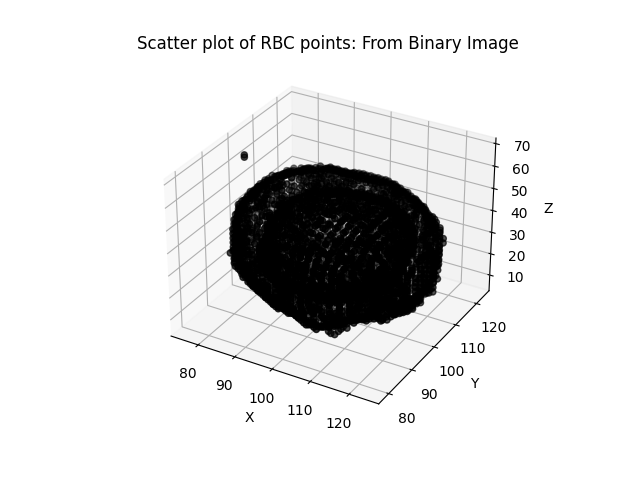
Made an image of RBC from vertice spatial locations in ChimeraX

In [ ]:
import skimage
skimage.measure.label(target_Binary)
fig= plt.figure()
ax = fig.add_subplot(111,projection='3d')
m= numpy.zeros((numpy.max(input_stepsx),numpy.max(input_stepsy),numpy.max(input_stepsz)))
pos = where(target_Binary==0)
ax.scatter(pos[0], pos[1], pos[2], c='black')
ax.set_title('Scatter plot of RBC points: From ConnectedComponents=0')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z') 
plt.show()


TargetGaussian=gaussian_filter(target_Binary,sigma 0.2)
targetGausErode1=binary_erosion(TargetGaussian,iterations=1)
targetGausErode2=binary_erosion(TargetGaussian,iterations=2)


fig= plt.figure()
ax = fig.add_subplot(111,projection='3d')
m= numpy.zeros((numpy.max(input_stepsx),numpy.max(input_stepsy),numpy.max(input_stepsz)))
pos = where(targetGausErode2 ==1)
ax.scatter(pos[0], pos[1], pos[2], c='black')
ax.set_title('Scatter plot of RBC points: gaussian filter sigma=0.2, erode iterations=2')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

fig= plt.figure()
ax = fig.add_subplot(111,projection='3d')
m= numpy.zeros((numpy.max(input_stepsx),numpy.max(input_stepsy),numpy.max(input_stepsz)))
pos = where(targetGausErode1 ==1)
ax.scatter(pos[0], pos[1], pos[2], c='black')
ax.set_title('Scatter plot of RBC points: gaussian filter sigma=0.2, erode iterations=2')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

skimage.morphology.remove_small_objects(

![Scatter plot of RBC points gaussian filter sigma 0_2.png](<attachment:Scatter plot of RBC points gaussian filter sigma 0_2.png>) ![Scatter plot of RBC points gaussian filter sigma0_2 erode iterations 2.png](<attachment:Scatter plot of RBC points gaussian filter sigma0_2 erode iterations 2.png>)![Scatter plot of RBC points gaussian filter sigma0_2 erode iterations 1.png](<attachment:Scatter plot of RBC points gaussian filter sigma0_2 erode iterations 1.png>)
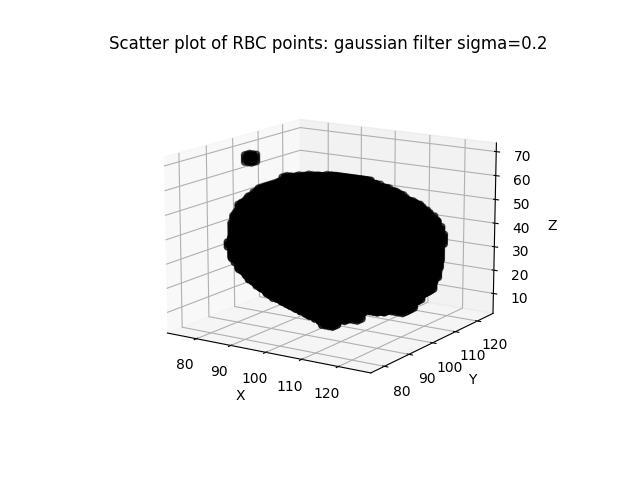
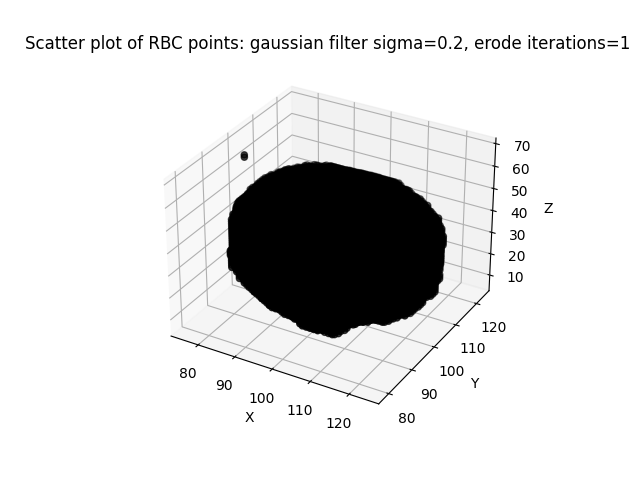
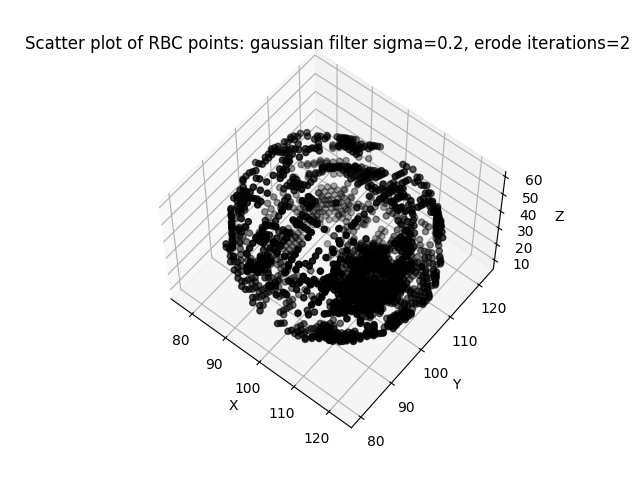

Here we should beable to id the outter surface by using z max size comparison of the connected components where we ask which value of connected components found are the largest.

In [ ]:
numpy.min(cc)
Out[210]: 0

numpy.max(cc)
Out[211]: 4


numpy.shape(where(cc == [0]))[1]
Out[249]: 9181776

numpy.shape(where(cc == [1]))[1]
Out[250]: 18220

numpy.shape(where(cc == [2]))[1]
Out[251]: 2

numpy.shape(where(cc == [3]))[1]
Out[252]: 1

maxs=numpy.zeros(numpy.max(cc))
for i in range (1 : numpy.max(cc)):
    maxs[i]=numpy.shape(where(cc == [i]))[1]

maxs
Out[260]: array([0.000e+00, 1.822e+04, 2.000e+00, 1.000e+00])

ind = numpy.where(maxs == numpy.max(maxs))

obj=numpy.where( cc==ind[0] )

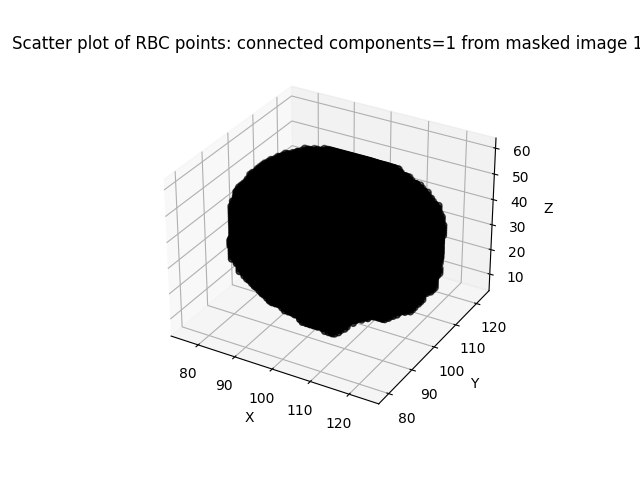 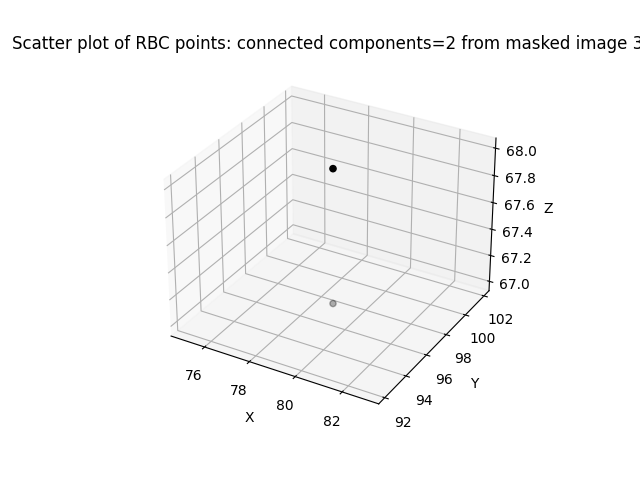 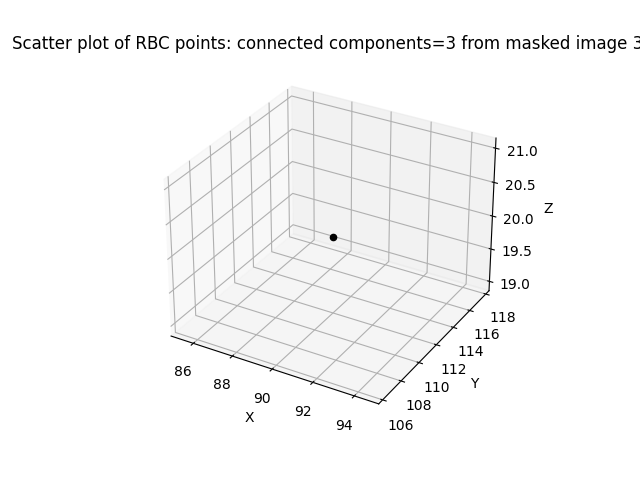 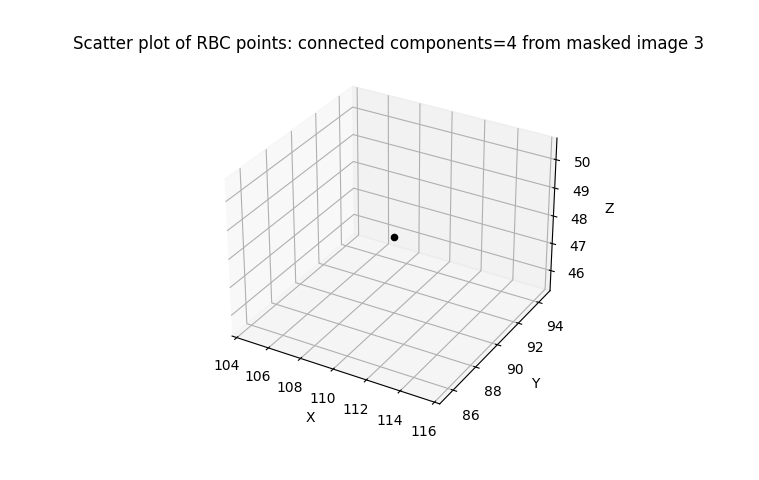